# DIGS 30009 Final Project - Coding-Based Analysis (12/12/2025)
## **Modeling Policing Data with Machine Learning**

### By Franklin Wang

This notebook presents a structured exploration of the sampled **National Repository of Policing Data (NRPD) events data from 2018**.  

My main analysis uses a combination of:
1. **Unsupervised learning** (e.g., K-Means) to identify structure in radio-zone activity  
2. **Supervised learning** (e.g., Linear Regression, Random Forest, Decision Tree) to estimate incident delay  

The goal of my final project is not to create high‑performance predictive models, but to demonstrate a methodological understanding of machine learning (ML), evaluate model behavior, and critically examine what ML can and cannot reveal about policing data. Instead, I focus on correct implementation, interpretation of results, and clear discussion of limitations.

## 1. Library Setup

In [44]:
# reference: housing price & titanic survival notebook syntax

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# unsupervised learning (no target variable)
from sklearn.preprocessing import StandardScaler    # feature scaling
from sklearn.decomposition import PCA               # dimension reduction
from sklearn.cluster import KMeans

# supervised learning (requires target variables)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

sns.set()
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

## 2. Dataset Overview: Source, Structure, and Descriptive Patterns

The dataset I am working with comes from the National Repository of Policing Data (NRPD), which I have been researching since June 2025. The sampled NRPD events dataset **(NRPD_events_2018.csv)** contains detailed records of police-related incidents from radio zones 1–13 in Chicago (excluding zones 7 and 9, which do not exist).

Each row in the dataset represents one police event. Some of these events come from 911 calls made by people in the city, and others are started by officers themselves, like traffic stops or situations they come across while on patrol. Each record includes an event ID, timestamps, location information, the type of call, and details about how the incident moved through the system.

I chose this dataset because I want to understand how police responses vary across different types of events and neighborhoods, and to examine how bias or inconsistency in the data might affect predictive-policing approaches. These patterns can also reveal how structural problems—such as uneven police presence or inconsistent reporting—shape what any machine-learning model is able to learn.

In [45]:
# load the entire dataset
df = pd.read_csv("NRPD_events_2018.csv")

In [46]:
# display a quick preview of the dataset
df.head()

,EVENT_NUMBER,RD,ENTRY_RECEIVED_DATE,DISPATCH_DATE,CALL_ACKNOWLEDGED_DATE,ON_SCENE_DATE,CLEARED_DATE,CLOSE COMPLETED DATE,PRIMARY UNIT,RADIO ZONE,...,INITIAL_DISPATCH_DESCRIPTION,FINAL_DISPATCH_CODE,PRIORITY_CODE,FINAL_DISPATCH_DESCRIPTION,FINAL_DISPOSITION_CODE,FINAL_DISPOSITION_DESCRIPTION,MENTAL,DOMESTIC,CALL_SOURCE,CALL_SOURCE_DESCRIPTION
0,1800100003,JB100016,2018-01-01 00:00:15,2018-01-01 00:00:38,2018-01-01 00:02:15,2018-01-01 00:05:16,2018-01-01 02:46:06,NaN,1723,1.00,...,BURGLARY JO,NaN,2B,NaN,1365,CRIM TRESS - RESIDENCE,N,N,E,E-911
1,1800100004,NaN,2018-01-01 00:00:16,2018-01-01 00:00:16,NaN,2018-01-01 00:00:16,2018-01-01 00:07:27,2018-01-01 00:07:27,1624,NaN,...,TRAFFIC STOP (OV),TS,3D,TRAFFIC STOP (OV),NaN,NaN,N,N,R,RADIO (ON VIEW)
2,1800100005,NaN,2018-01-01 00:00:21,2018-01-01 00:01:24,2018-01-01 00:03:33,2018-01-01 00:08:15,2018-01-01 00:44:11,2018-01-01 00:44:11,634R,8.00,...,BATTERY IP,BATIP,1A,BATTERY IP,1PZ,DomDist;MenHlth;Ot,Y,Y,E,E-911
3,1800100006,NaN,2018-01-01 00:00:24,2018-01-01 00:00:24,2018-01-01 00:00:41,2018-01-01 00:00:24,2018-01-01 00:08:39,2018-01-01 00:08:39,3211,NaN,...,PREMISE CHECK [OV],PRE,4,PREMISE CHECK [OV],19P,MISC.INC./OTH POLICE SER,N,N,R,RADIO (ON VIEW)
4,1800100008,NaN,2018-01-01 00:00:30,2018-01-01 00:09:29,NaN,NaN,2018-01-01 00:09:31,2018-01-01 00:09:31,1030,10.00,...,SHOTS FIRED,SHOTSF,1A,SHOTS FIRED,19P,MISC.INC./OTH POLICE SER,N,N,E,E-911


The NRPD events dataset shows a lot of variation in how complete the records are. Missing data is expected in police dispatch systems because different officers, procedures, and data-entry practices can lead to gaps or inconsistencies.

In [47]:
# (rows, columns)
df.shape

(1048001, 33)

In [48]:
# check dataframe structure and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048001 entries, 0 to 1048000
Data columns (total 33 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   EVENT_NUMBER                   1048001 non-null  int64  
 1   RD                             159467 non-null   object 
 2   ENTRY_RECEIVED_DATE            1048001 non-null  object 
 3   DISPATCH_DATE                  966338 non-null   object 
 4   CALL_ACKNOWLEDGED_DATE         522220 non-null   object 
 5   ON_SCENE_DATE                  737737 non-null   object 
 6   CLEARED_DATE                   966356 non-null   object 
 7   CLOSE COMPLETED DATE           1045192 non-null  object 
 8   PRIMARY UNIT                   1024591 non-null  object 
 9   RADIO ZONE                     610691 non-null   float64
 10  BEAT OF OCCURRENCE             612627 non-null   float64
 11  DISTRICT OF OCCURRENCE         612627 non-null   float64
 12  SERVICE HOUSE 

Even though missing data is expected in the NRPD, the amount of missing information in this dataset is still noticeable. In particular, a substantial number of events lack a recorded final outcome, which raises questions about how complete the data is and how the missing pieces could affect the analysis later on.

In [49]:
# view summary statistics for the first 20 rows
df.describe().head(20)

,EVENT_NUMBER,RADIO ZONE,BEAT OF OCCURRENCE,DISTRICT OF OCCURRENCE,BEAT_OF_SERVICE,AREA_OF_SERVICE,SECTOR_OF_SERVICE
count,1048001.00,610691.00,612627.00,612627.00,612673.00,617658.00,612673.00
mean,1806924400.62,7.54,1174.77,11.52,1175.73,2.86,2.00
std,3829671.78,3.63,710.14,7.10,711.25,1.44,0.83
min,1800100003.00,1.00,111.00,1.00,111.00,0.00,0.00
25%,1803607272.00,4.00,613.00,6.00,613.00,2.00,1.00
50%,1807009042.00,8.00,1111.00,11.00,1111.00,3.00,2.00
75%,1810302922.00,10.00,1732.00,17.00,1732.00,4.00,3.00
max,1813306056.00,13.00,4100.00,41.00,4100.00,5.00,5.00


I noticed that some beat values ranged from 111 to 3100, which is unusual because Chicago police beats usually follow a three-digit structure. This suggests that the beat field in this dataset may be coded differently or combined with another geographic system rather than using the standard CPD beat numbering.

I also found that the radio zone values produced misleading averages because pandas read them as numbers even though they are really just labels from 1 to 13. This does not mean the data is incorrect, but it does affect how the variable behaves in analysis.

In [50]:
# these fields are codes, not real numbers, so convert them to categorical types

categorical_cols = [
    'EVENT_NUMBER',
    'RADIO ZONE',
    'BEAT OF OCCURRENCE',
    'DISTRICT OF OCCURRENCE',
    'BEAT_OF_SERVICE',
    'AREA_OF_SERVICE',
    'SECTOR_OF_SERVICE'
]

for col in categorical_cols:
    df[col] = df[col].astype('category')

For the scope of my final project analysis, I keep a smaller set of variables that relate to location, event type, and time-based delay.

In [51]:
cols_to_keep = [
    'RADIO ZONE',
    'BEAT_OF_SERVICE',
    'DISTRICT',
    'FINAL_DISPATCH_DESCRIPTION',
    'ENTRY_RECEIVED_DATE',
    'ON_SCENE_DATE'
]

df = df[cols_to_keep]
df.head()

,RADIO ZONE,BEAT_OF_SERVICE,DISTRICT,FINAL_DISPATCH_DESCRIPTION,ENTRY_RECEIVED_DATE,ON_SCENE_DATE
0,1.00,1723.00,017,NaN,2018-01-01 00:00:15,2018-01-01 00:05:16
1,NaN,NaN,016,TRAFFIC STOP (OV),2018-01-01 00:00:16,2018-01-01 00:00:16
2,8.00,634.00,006,BATTERY IP,2018-01-01 00:00:21,2018-01-01 00:08:15
3,NaN,NaN,CW1,PREMISE CHECK [OV],2018-01-01 00:00:24,2018-01-01 00:00:24
4,10.00,1011.00,010,SHOTS FIRED,2018-01-01 00:00:30,NaN


In [52]:
df.dtypes

,0
RADIO ZONE,category
BEAT_OF_SERVICE,category
DISTRICT,object
FINAL_DISPATCH_DESCRIPTION,object
ENTRY_RECEIVED_DATE,object
ON_SCENE_DATE,object


I kept these columns because they are the most relevant for understanding where the call occurred, what type of event it was, and how long the response took. Radio zone, beat, and district capture the spatial context, the final dispatch description shows how the call was ultimately classified, and the two timestamps allow me to measure response time. The remaining fields are not necessary for the goals of this analysis.

## 3. Calculating Incident Delay  

In [53]:
df['ENTRY_RECEIVED_DATE'] = pd.to_datetime(df['ENTRY_RECEIVED_DATE'])
df['ON_SCENE_DATE'] = pd.to_datetime(df['ON_SCENE_DATE'])

df = df.dropna(subset=['ENTRY_RECEIVED_DATE', 'ON_SCENE_DATE'])

df['INCIDENT_DELAY'] = (df['ON_SCENE_DATE'] - df['ENTRY_RECEIVED_DATE']).dt.total_seconds() / 60
df = df[df['INCIDENT_DELAY'] >= 0] # remove negative delays (unrealistic in real-life policing)

In [54]:
df[['RADIO ZONE', 'INCIDENT_DELAY']]

,RADIO ZONE,INCIDENT_DELAY
0,1.00,5.02
1,NaN,0.00
2,8.00,7.90
3,NaN,0.00
5,NaN,0.00
...,...,...
1047994,12.00,143.70
1047995,NaN,0.00
1047996,NaN,0.00
1047997,10.00,0.00


In [55]:
# looking closely at the 'INCIDENT_DELAY' column (second to last of the dataframe)
df['INCIDENT_DELAY'].describe()
df.sort_values('INCIDENT_DELAY', ascending=False).head(20)

,RADIO ZONE,BEAT_OF_SERVICE,DISTRICT,FINAL_DISPATCH_DESCRIPTION,ENTRY_RECEIVED_DATE,ON_SCENE_DATE,INCIDENT_DELAY
115887,5.00,225.00,002,INFO. FOR THE POLICE,2018-01-17 11:39:55,2018-01-19 08:23:58,2684.05
963289,13.00,934.00,009,NaN,2018-05-04 00:42:40,2018-05-05 20:22:23,2619.72
168777,6.00,714.00,007,DISTURBANCE,2018-01-24 09:30:50,2018-01-25 13:51:11,1700.35
326702,5.00,223.00,002,NaN,2018-02-14 14:54:49,2018-02-15 18:25:02,1650.22
603789,12.00,1522.00,015,DETAIL,2018-03-21 13:23:46,2018-03-22 15:17:43,1553.95
810973,9.00,2234.00,022,MISSING PER. TENDER AGE,2018-04-16 13:05:30,2018-04-17 12:02:14,1376.73
166498,1.00,1711.00,017,NaN,2018-01-23 22:04:23,2018-01-24 19:29:35,1285.20
346380,NaN,3100.00,031,DETAIL,2018-02-17 04:35:18,2018-02-17 23:15:27,1120.15
113706,11.00,2031.00,020,DETAIL,2018-01-17 01:06:55,2018-01-17 18:27:41,1040.77
737036,13.00,915.00,009,DETAIL,2018-04-07 06:00:35,2018-04-07 21:40:15,939.67


Using **.dt.total_seconds() / 60** converts the time difference into minutes, which is easier to read. I also removed negative delays because they are not possible in real situations and usually come from timestamp errors.

When I calculated the delay values, most events showed short and realistic times, usually under an hour. A small number of events showed extremely large delays, sometimes more than 2,500 minutes (almost two days). Police would not take that long to arrive, so these values are not real response times. These outliers come from missing or incomplete ON_SCENE_DATE values. In many cases, the arrival time was never entered in the system, and the CAD software later filled in a close-out timestamp instead. This makes the delay appear much larger than it actually was.

There are also many cases where the delay is zero. A zero delay does not mean officers arrived instantly. It usually happens when the dataset is missing the true arrival time or when the system assigns the same timestamp to both ENTRY_RECEIVED_DATE and ON_SCENE_DATE. These zero and extremely large delays both reflect data-entry issues rather than actual policing behavior. So, incident delay is only an approximate measure and does not represent the exact response time.

In [56]:
df['RADIO ZONE'] = df['RADIO ZONE'].astype(float)
df['BEAT_OF_SERVICE'] = df['BEAT_OF_SERVICE'].astype(float)

# drop rows missing the columns i'm keeping
df = df.dropna(subset=['RADIO ZONE', 'BEAT_OF_SERVICE', 'INCIDENT_DELAY'])

# drop the district column completely
df = df.drop(columns=['DISTRICT'])

df[['RADIO ZONE','BEAT_OF_SERVICE','INCIDENT_DELAY']].head()

,RADIO ZONE,BEAT_OF_SERVICE,INCIDENT_DELAY
0,1.00,1723.00,5.02
2,8.00,634.00,7.90
8,6.00,832.00,12.38
10,6.00,711.00,21.95
11,8.00,422.00,54.73


I decided to cluster events around zones, so I kept the radio zone variable in the dataset. The values that appear as 1.00 or 9.00 are just how pandas prints numeric fields, and they still refer to the same zones. The variable remains meaningful for the analysis.

I removed the district variable because it either duplicated information already captured by radio zones and beats or introduced missing values that did not help the clustering.

I also recognize that dropping rows with missing values removes a large number of observations, which is a clear limitation. This can affect how certain zones or beats appear in the results. Even so, the clustering method needs complete zone information, so removing those rows is necessary for the analysis to run correctly.

With these changes, the dataset shows clearer differences in response delays across zones and beats. These differences are important for identifying the clustering patterns I am trying to study in my final project.

## 4. Exploratory Visualization

In [57]:
# the sort.index() function sorts the table from min to max
df['RADIO ZONE'].value_counts().sort_index()

,count
RADIO ZONE,
1.00,22266
2.00,11153
3.00,8702
4.00,25662
5.00,13761
6.00,40353
7.00,18165
8.00,48226
9.00,22595


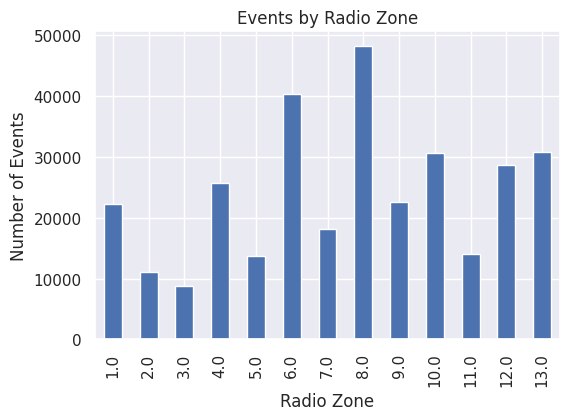

In [58]:
plt.figure(figsize=(6,4))
df['RADIO ZONE'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Radio Zone')
plt.ylabel('Number of Events')
plt.title('Events by Radio Zone')
plt.show()

From the bar chart on the 2018 events data, it is clear that Zone 8 has the highest number of events, while Zone 3 has the lowest.

In [59]:
df['FINAL_DISPATCH_DESCRIPTION'].value_counts().head(10)

,count
FINAL_DISPATCH_DESCRIPTION,
TRAFFIC STOP (OV),40680
DISTURBANCE,23682
DOMESTIC DISTURBANCE,20589
ALARM BURGLAR,16925
CHECK WELL BEING,9993
ALARM COMMERCIAL,7256
BATTERY IP,6435
SUSPICIOUS PERSON,6383
PARKING VIOL. 1,6273


I used **FINAL_DISPATCH_DESCRIPTION** for the top-10 event types because it gives the clearest idea of what officers were actually sent to. The INITIAL_DISPATCH_DESCRIPTION column is often incomplete or changes quickly, so it is not very helpful for a simple count of common event types. The FINAL_DISPOSITION_DESCRIPTION column shows how events ended, which is not what I am looking at here. Using FINAL_DISPATCH_DESCRIPTION makes the most sense for showing the main types of calls that were dispatched.

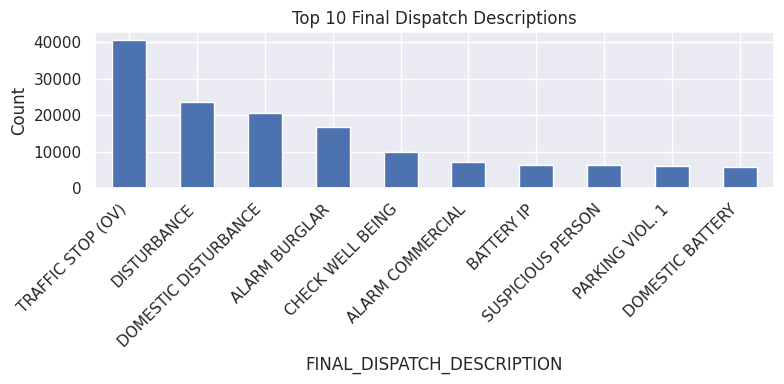

In [60]:
plt.figure(figsize=(8,4))
df['FINAL_DISPATCH_DESCRIPTION'].value_counts().head(10).plot(kind='bar')
plt.xticks(rotation=45, ha='right') # this line makes the labels easier to read for aesthetic purposes
plt.ylabel('Count')
plt.title('Top 10 Final Dispatch Descriptions')
plt.tight_layout()
plt.show()

This bar chart shows the top ten **FINAL_DISPATCH_DESCRIPTION** categories and gives a sense of which calls officers respond to most often. Traffic stops are the most common, followed by disturbances, domestic disturbances, and alarm-related calls. The fact that “disturbance” and “domestic disturbance” appear as separate categories reflects how similar situations can appear under different labels in dispatch data. For machine learning, this can help because it gives more detail, but it can also make things harder if the categories overlap or are not used consistently.

<Figure size 800x400 with 0 Axes>

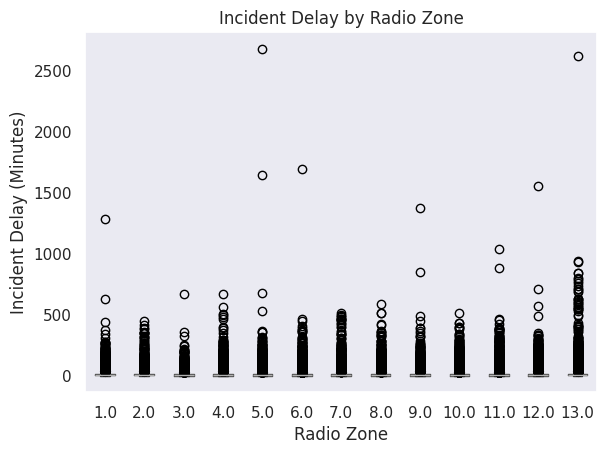

In [61]:
plt.figure(figsize=(8,4))
df.boxplot(column='INCIDENT_DELAY', by='RADIO ZONE', grid=False)
plt.suptitle('')
plt.xlabel('Radio Zone')
plt.ylabel('Incident Delay (Minutes)')
plt.title('Incident Delay by Radio Zone')
plt.show()

This boxplot shows how incident delay varies across radio zones. The x-axis lists zones and the y-axis shows delay in minutes. Most events have short delays, usually under an hour. A small number of events show extremely large delays, but these values are not realistic response times. They likely come from missing or incorrect timestamps, such as arrival times that were never entered or were replaced by a much later system time.

## 5. Unsupervised: K-means clustering around zones

Before running K-means, I used the elbow method to help decide how many clusters to use instead of picking a random number. I wrote a small function that tests values of k from 1 to 10 and records the inertia for each one. Inertia measures how tightly the points fit within each cluster, so the elbow curve helps show where adding more clusters stops making a big difference.

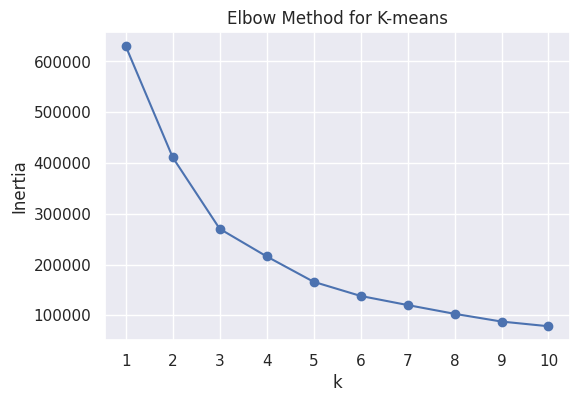

In [62]:
# elbow method for choosing k (source: week 9 lecture)
def kmeans_elbow(X, max_k=10, random_state=42):
    inertias = []
    Ks = list(range(1, max_k+1))
    for k in Ks:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        km.fit(X)
        inertias.append(km.inertia_)
    return Ks, inertias

# prepare data for clustering
X_clust = df[['RADIO ZONE', 'INCIDENT_DELAY']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

# run elbow method
Ks, inertias = kmeans_elbow(X_scaled, max_k=10)

# plot the elbow curve
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-means')
plt.xticks(Ks)
plt.show()

The elbow plot shows how inertia drops as the number of clusters increases. The biggest decreases happen between k = 1 and k = 3, and then the curve starts to level off around k = 4. After k = 4 or 5, the improvements become much smaller. Based on this shape, the best choice for k is around 4, since that is where the curve slows down and adding more clusters no longer helps much.

The inertia values look very large because the NRPD dataset has many events. With tens of thousands of rows, these numbers get big quickly, so high inertia is normal and not a problem. What matters is the trend in the elbow-method curve, not the actual size of the values.

In [63]:
# select the features
X_clust = df[['RADIO ZONE','INCIDENT_DELAY']]

# scaling: for both features to be on the same scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

# run the k-means model with k = 4
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

df['cluster'] = clusters
df[['RADIO ZONE','INCIDENT_DELAY','cluster']].head()

,RADIO ZONE,INCIDENT_DELAY,cluster
0,1.00,5.02,1
2,8.00,7.90,0
8,6.00,12.38,1
10,6.00,21.95,1
11,8.00,54.73,3


In [64]:
df['cluster'].value_counts().sort_index()

,count
cluster,
0,162328
1,131682
2,966
3,20027


I noticed that cluster 2 is much smaller than the others, with only 966 events, while the other clusters have tens of thousands. I am guessing this happens because these 966 events are really different from the rest of the data. They might have extremely long delays or unusual combinations of radio zone and delay that make them stand out. Since K-means groups similar points together, it pushed these events into their own small cluster. This does not mean the clustering is wrong, but it does suggest that cluster 2 contains outliers or unusual cases, and I want to look more closely at them to see what makes them so different from the typical events.

In [65]:
# filter only cluster 2
cluster2_df = df[df['cluster'] == 2]
cluster2_df.head()

,RADIO ZONE,BEAT_OF_SERVICE,FINAL_DISPATCH_DESCRIPTION,ENTRY_RECEIVED_DATE,ON_SCENE_DATE,INCIDENT_DELAY,cluster
199,13.00,1221.00,PARKING VIOL. 2,2018-01-01 00:21:54,2018-01-01 03:53:11,211.28,2
1070,13.00,912.00,NaN,2018-01-01 02:20:39,2018-01-01 09:33:48,433.15,2
1134,5.00,213.00,NaN,2018-01-01 02:30:02,2018-01-01 06:17:03,227.02,2
1664,10.00,1111.00,ANIMAL BITE,2018-01-01 03:50:25,2018-01-01 09:29:12,338.78,2
1699,4.00,113.00,NaN,2018-01-01 03:58:22,2018-01-01 07:00:33,182.18,2


In [66]:
# cluster2_df['INCIDENT_DELAY'].describe()
# cluster2_df['RADIO ZONE'].value_counts()

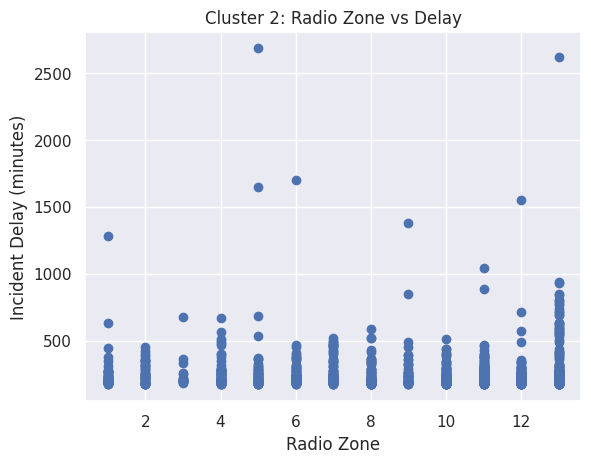

In [67]:
plt.scatter(cluster2_df['RADIO ZONE'], cluster2_df['INCIDENT_DELAY'])
plt.xlabel('Radio Zone')
plt.ylabel('Incident Delay (minutes)')
plt.title('Cluster 2: Radio Zone vs Delay')
plt.show()

The scatter plot for cluster 2 shows that most points are at lower delays, but there are several extreme outliers with delays over 2,500 minutes. These unusual values are very different from most events, which is why K-means put them in their own small cluster. This does not ruin the clustering, but the extreme delays do affect the results and can influence the other cluster centers. If I want more typical clusters, I could consider removing these extreme values before running K-means.

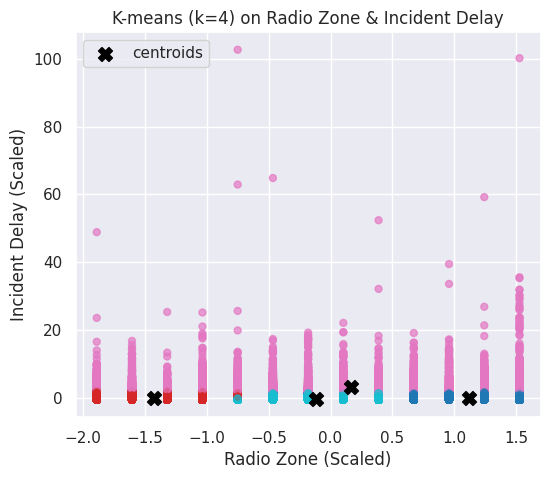

In [68]:
# source: week 9 lecture (Clustering_KMeans_GMM_DBSCAN.ipynb)

# fit and plot k-means for k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_scaled)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

plt.figure(figsize=(6,5))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels, cmap='tab10', s=25, alpha=0.7)
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, marker='X', label='centroids')
plt.xlabel('Radio Zone (Scaled)')
plt.ylabel('Incident Delay (Scaled)')
plt.title('K-means (k=4) on Radio Zone & Incident Delay')
plt.legend()
plt.show()

The K-means plot looks unusual because radio zone is a categorical variable, but it was treated as numeric for clustering. This causes all events from the same zone to line up at the same x-value in the plot. The delay values also include very large outliers, and even after scaling, these points still pull the clusters in certain directions. Because K-means relies on numerical distance, treating radio zone this way affects how events are grouped. As a result, the clusters overlap heavily and should not be interpreted as strong or meaningful patterns. Overall, the plot highlights general differences in delay but also shows why this dataset is difficult to cluster using K-means.

### 5.1 Most Common Event Types by Police Zone

In [69]:
zone_event_counts = (
    df.groupby(['RADIO ZONE', 'FINAL_DISPATCH_DESCRIPTION'])
      .size()
      .reset_index(name='count')
)

# get the most common event per zone
zone_top1 = (
    zone_event_counts
      .sort_values(['RADIO ZONE', 'count'], ascending=[True, False])
      .groupby('RADIO ZONE')
      .head(1)
)

zone_top1

,RADIO ZONE,FINAL_DISPATCH_DESCRIPTION,count
64,1.00,DISTURBANCE,1748
224,2.00,DISTURBANCE,1184
456,3.00,TRAFFIC STOP (OV),1013
534,4.00,DISTURBANCE,3730
790,5.00,TRAFFIC STOP (OV),1578
981,6.00,TRAFFIC STOP (OV),5888
1150,7.00,TRAFFIC STOP (OV),3090
1341,8.00,TRAFFIC STOP (OV),9038
1516,9.00,TRAFFIC STOP (OV),3011
1691,10.00,TRAFFIC STOP (OV),3041


I also examined descriptive statistics to understand what types of events are common in each radio zone. This analysis does not affect the K-Means model directly, but it helps interpret why zones differ and provides context for the patterns seen in the clusters. I found that **most zones (5–13) are dominated by traffic stops, while zones 1, 2, and 4 report more disturbance calls**.

### 5.2 Isolate one zone and see what happens most often

In [70]:
zone_of_interest = df['RADIO ZONE'].value_counts().idxmax()

In [71]:
# focusing (isolating) the zone with the most events
zone8_df = df[df['RADIO ZONE'] == zone_of_interest]
print(f"Number of events in zone {zone_of_interest}: {len(zone8_df)}")

Number of events in zone 8.0: 48226


In [72]:
# top 10 most common final dispatch description types in zone 8
zone8_df['FINAL_DISPATCH_DESCRIPTION'].value_counts().head(10)

,count
FINAL_DISPATCH_DESCRIPTION,
TRAFFIC STOP (OV),9038
DOMESTIC DISTURBANCE,3874
ALARM BURGLAR,3483
DISTURBANCE,2958
CHECK WELL BEING,1307
DOMESTIC BATTERY,1076
STREET STOP,977
BATTERY IP,885
ALARM COMMERCIAL,818


In [73]:
zone8_df['INCIDENT_DELAY'].describe()

,INCIDENT_DELAY
count,48226.00
mean,11.95
std,20.82
min,0.00
25%,0.00
50%,5.83
75%,14.27
max,589.22


Zone 8 has 48,226 delay values. Most delays are short, but a few very large delays are not realistic and likely come from missing or incorrect timestamps. These extreme values (like 589 minutes) pull the average up, so the median delay (6 minutes) gives a better picture of what usually happens. A 6-minute delay also makes sense because officers are already spread out around the city, not far away, so they can usually reach a call fairly quickly.

## 6. Supervised: Classic linear regression for 'INCIDENT_DELAY'

A lot of the columns in the NRPD events dataset are not very useful for prediction. Many of them are just ID numbers, internal codes, or text labels that do not turn into helpful numeric features. Because of that, a regular regression model would not work well unless the features are cleaned and rebuilt. The time-based columns are the only ones that consistently behave like real numeric data, so they are the most reliable features for predicting delay.

For the supervised learning part, my goal is mainly to show that I understand the basic workflow. I split the data into a training set (70%), a validation set (15%), and a test set (15%). This gives me enough data to train the model while still keeping separate sets to check how well it performs on new, unseen events.

In [74]:
# creating time-of-day
df['TIME_OF_DAY'] = df['ENTRY_RECEIVED_DATE'].dt.hour

In [75]:
# pick the features i want to use
feature_cols = ['RADIO ZONE', 'BEAT_OF_SERVICE', 'TIME_OF_DAY', 'FINAL_DISPATCH_DESCRIPTION']

X = df[feature_cols].copy()

# turn event type into dummies
X = pd.get_dummies(X, columns=['FINAL_DISPATCH_DESCRIPTION'], drop_first=True)

# target
y = df['INCIDENT_DELAY'].copy()

X.head()

,RADIO ZONE,BEAT_OF_SERVICE,TIME_OF_DAY,FINAL_DISPATCH_DESCRIPTION_10-1 OV,FINAL_DISPATCH_DESCRIPTION_ABANDONDED BUILDINGS (ON VIEW),FINAL_DISPATCH_DESCRIPTION_ADMIN. NOTICE OF ORD. VIOL.,FINAL_DISPATCH_DESCRIPTION_ALARM AUTO,FINAL_DISPATCH_DESCRIPTION_ALARM BURGLAR,FINAL_DISPATCH_DESCRIPTION_ALARM BUS,FINAL_DISPATCH_DESCRIPTION_ALARM CARBON MONOXIDE,...,FINAL_DISPATCH_DESCRIPTION_TRUANT,FINAL_DISPATCH_DESCRIPTION_UNATTENDED PACKAGES,FINAL_DISPATCH_DESCRIPTION_VICE COMPLAINTS IP,FINAL_DISPATCH_DESCRIPTION_VICE COMPLAINTS ROUTINE,FINAL_DISPATCH_DESCRIPTION_VIOLATION ORDER OF PROT,FINAL_DISPATCH_DESCRIPTION_VOOP - Cindy Bischof' Law,FINAL_DISPATCH_DESCRIPTION_WALK DOWN,FINAL_DISPATCH_DESCRIPTION_WEAPONS VIOLATION,FINAL_DISPATCH_DESCRIPTION_WHEEL CHAIR TRANSPORT,FINAL_DISPATCH_DESCRIPTION_WIRES DOWN
0,1.00,1723.00,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,8.00,634.00,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,6.00,832.00,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,6.00,711.00,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11,8.00,422.00,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [76]:
# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=0
)

# split temp into 15% val and 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=0
)

print('Train size:', len(X_train))
print('Val size:', len(X_val))
print('Test size:', len(X_test))

Train size: 220502
Val size: 47250
Test size: 47251


In [77]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_train = lin_reg.predict(X_train)
y_pred_val = lin_reg.predict(X_val)
y_pred_test = lin_reg.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)

print('Linear regression results:')
print('Train R^2:', round(r2_train, 3))
print('Test  R^2:', round(r2_test, 3))
print('Train MSE:', round(mse_train, 2))
print('Val   MSE:', round(mse_val, 2))
print('Test  MSE:', round(mse_test, 2))

Linear regression results:
Train R^2: 0.158
Test  R^2: 0.179
Train MSE: 599.44
Val   MSE: 448.42
Test  MSE: 525.54


The linear regression model did not perform very well. The R^2 scores were low (0.158-0.179), which means the model could only explain about 15% to 18% of why some delays are longer than others. This makes sense because delay depends on many factors that are not captured in the dataset. The high MSE numbers also show that zone, beat, and event type are not strong predictors. The train and test scores are similar, so the model is not overfitting; it just does not have enough useful features to make good predictions.

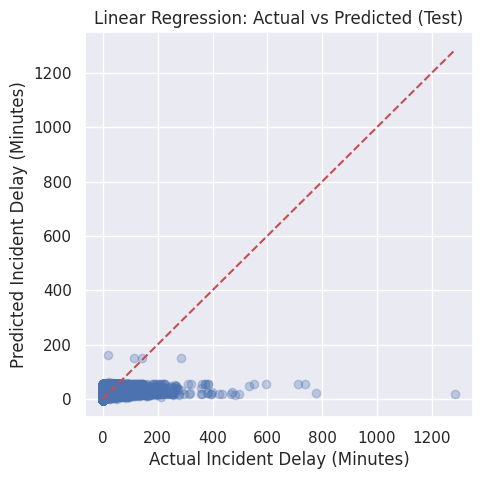

In [78]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.xlabel('Actual Incident Delay (Minutes)')
plt.ylabel('Predicted Incident Delay (Minutes)')
plt.title('Linear Regression: Actual vs Predicted (Test)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

This plot shows that the linear regression model cannot learn the pattern in incident delay. Most predictions stay close to zero, even when the real delays are much higher. This usually means the data is not linear and the weak features do not explain delay very well. Linear regression also assumes a simple straight-line relationship, which does not fit how police response times actually work. Because of this, the model performs poorly even though my code is correct.

## 7. Random Forest Regression

In [79]:
# source: week 9 lecture (Decision_Tree_and_Random_Forest.ipynb)

# faster version: reduce with max_depth for stopping tree growths and n_jobs for CPU
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    n_jobs=-1,
    random_state=0
)
rf.fit(X_train, y_train)

rf_pred_train = rf.predict(X_train)
rf_pred_val = rf.predict(X_val)
rf_pred_test = rf.predict(X_test)

rf_r2_train = r2_score(y_train, rf_pred_train)
rf_r2_test = r2_score(y_test, rf_pred_test)
rf_mse_train = mean_squared_error(y_train, rf_pred_train)
rf_mse_val = mean_squared_error(y_val, rf_pred_val)
rf_mse_test = mean_squared_error(y_test, rf_pred_test)

print('Random forest results:')
print('Train R^2:', round(rf_r2_train, 3))
print('Test  R^2:', round(rf_r2_test, 3))
print('Train MSE:', round(rf_mse_train, 2))
print('Val   MSE:', round(rf_mse_val, 2))
print('Test  MSE:', round(rf_mse_test, 2))

Random forest results:
Train R^2: 0.169
Test  R^2: 0.161
Train MSE: 591.28
Val   MSE: 463.44
Test  MSE: 536.49


## 8. Decision Tree

In [80]:
# source: week 9 lecture (Decision_Tree_and_Random_Forest.ipynb)

# train Decision Tree
dt_model = DecisionTreeRegressor(
    random_state=42,
    max_depth=6   # prevents huge overfitting
)
dt_model.fit(X_train, y_train)

# predictions
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)

# evaluation
print("Decision Tree Regression Results")
print("Train R^2:", round(r2_score(y_train, dt_train_pred), 3))
print("Test  R^2:", round(r2_score(y_test, dt_test_pred), 3))
print("Train MSE:", round(mean_squared_error(y_train, dt_train_pred), 2))
print("Test  MSE:", round(mean_squared_error(y_test, dt_test_pred), 2))

# tree characteristics
print("Tree Depth:", dt_model.get_depth())
print("Number of Leaves:", dt_model.get_n_leaves())


Decision Tree Regression Results
Train R^2: 0.099
Test  R^2: 0.109
Train MSE: 641.52
Test  MSE: 570.19
Tree Depth: 6
Number of Leaves: 60


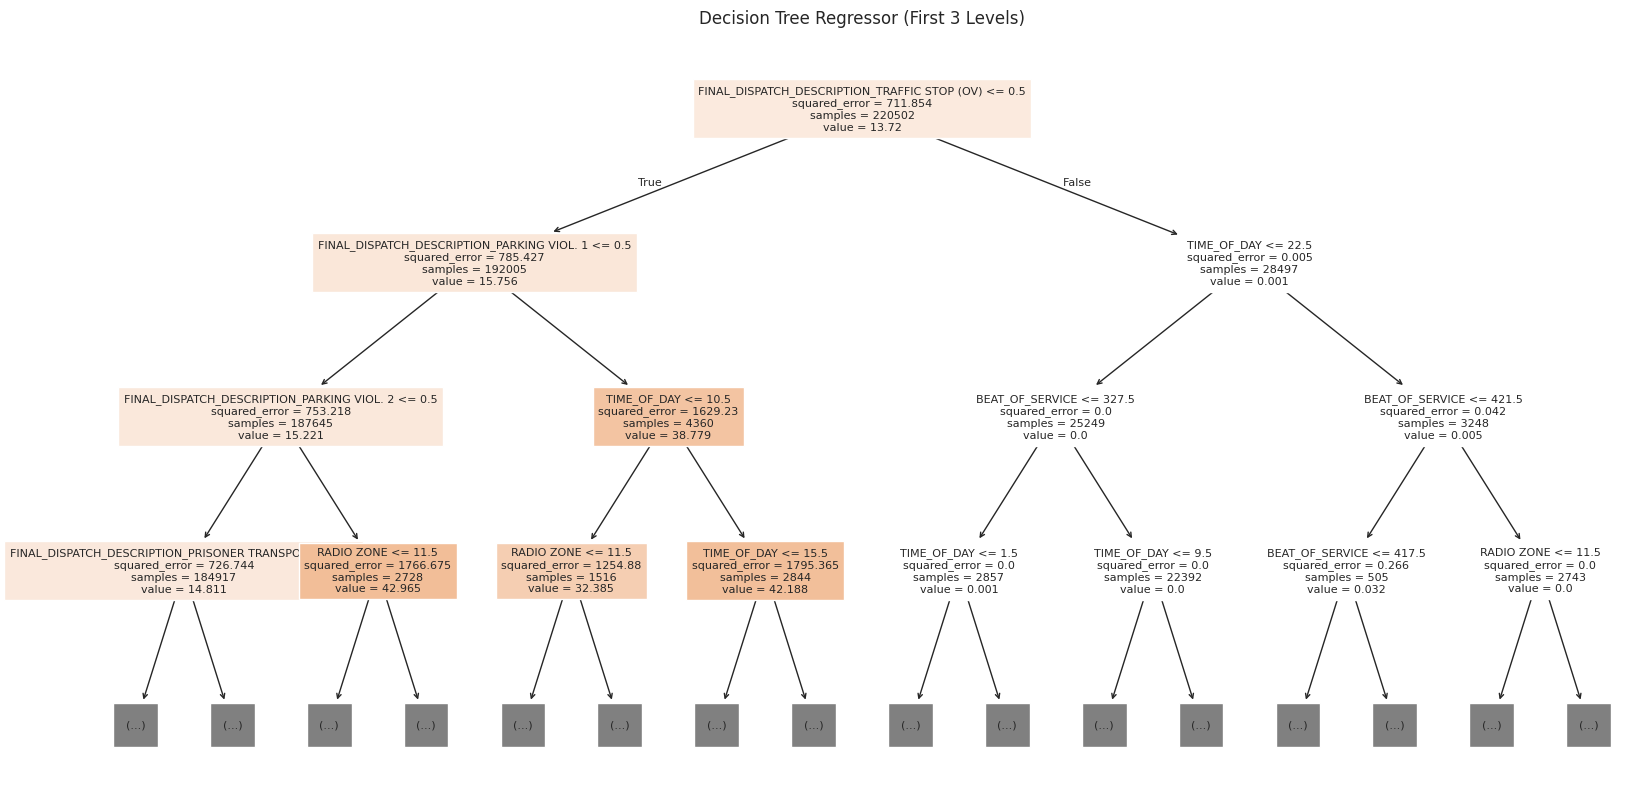

In [81]:
plt.figure(figsize=(20,10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    filled=True,
    max_depth=3,  # shows first 3 levels
    fontsize=8
)
plt.title("Decision Tree Regressor (First 3 Levels)")
plt.show()

The decision tree is difficult to interpret because the dataset does not clearly explain why some events have longer delays than others. Since the model cannot find strong patterns, it keeps creating very small splits that do not mean much. Many of the branches end up predicting a delay of 0 minutes because there are many missing or repeated timestamps in the data.

Overall, the tree does not show clear or useful decision rules. It mostly reflects noise in the dataset and shows that the features available, such as zone, beat, time of day and event type, do not provide enough information to predict incident delay well.

## 9. Compare Different ML Models

In [82]:
# predictions
dt_train_pred = dt_model.predict(X_train)
dt_val_pred   = dt_model.predict(X_val)
dt_test_pred  = dt_model.predict(X_test)

# R^2 scores
dt_r2_train = r2_score(y_train, dt_train_pred)
dt_r2_test  = r2_score(y_test, dt_test_pred)

# MSE scores
dt_mse_train = mean_squared_error(y_train, dt_train_pred)
dt_mse_val   = mean_squared_error(y_val, dt_val_pred)
dt_mse_test  = mean_squared_error(y_test, dt_test_pred)

In [83]:
results = pd.DataFrame({
    'model': ['Linear Regression','Random Forest','Decision Tree'],
    'train_R2': [r2_train, rf_r2_train, dt_r2_train],
    'test_R2':  [r2_test, rf_r2_test, dt_r2_test],
    'val_MSE':  [mse_val, rf_mse_val, dt_mse_val],
    'test_MSE': [mse_test, rf_mse_test, dt_mse_test]
})

results

,model,train_R2,test_R2,val_MSE,test_MSE
0,Linear Regression,0.16,0.18,448.42,525.54
1,Random Forest,0.17,0.16,463.44,536.49
2,Decision Tree,0.10,0.11,487.66,570.19


## 10. Concluding Remarks / Criticism and Outlook

In my final project, I used both unsupervised and supervised learning to understand patterns in the 2018 NRPD events data. The K-means clustering showed that the clearest separation in the dataset comes from differences in incident delay. When I looked at the most common call types in each zone, I saw that zones have different patterns of activity, which helped explain some of the clustering results.

For prediction, I tested linear regression, random forest, and a small decision tree. All three models produced low R^2 scores and high errors. This shows that radio zone, beat, time of day, and event type do not explain incident delay very well. The weak results make sense because the dataset is mostly categorical and does not include the real factors that drive police response time, such as distance, traffic, staffing, or dispatch priorities. This pattern reflects data limitations, not my modeling approaches.

Going forward, if I had more time and resources, I could try improving the models by adding richer numeric features. I could also try grouping event types into broader categories or reducing the number of dummy variables. Another possibility would be choosing a different target variable entirely, since incident delay may not be predictable from the columns available in this dataset. A target that comes directly from cleaner numeric fields might work better.

**Overall, I believe I demonstrated a solid understanding of basic machine learning methods, and this project also helped me see how limitations and biases in policing data shape what models can and cannot learn, showing that data quality matters as much as model choice.**